# Implement AdaBoost with decision stumps, i.e., 1-level decision trees
In this question, you will implement the AdaBoost algorithm with decision stumps, i.e., 1-level decision trees.
You will need to implement the adaboost algorithm from scratch and train and test the classifier on the
dataset provided

In [69]:
import numpy as np
import matplotlib.pyplot as plt

- if polarity is 1: 
    - x< threshold: class -1
    - x > threshold: class 1
- if polarity is -1: 
    - x> threshold: class -1
    - x < threshold: class 1

In [70]:
class Weak_Learner:
    def __init__(self):
        self.threshold = None
        self.alpha = None
        self.feature_index = None
        self.polarity = 1
        

    def learner_predict(self, X):
        n_datapoints = X.shape[0]
        feature = X[:, self.feature_index]
        predictions = np.ones(n_datapoints) # initiate with 1 for all and switch to -1 where necessary
        
        if self.polarity==1:
            predictions [feature < self.threshold] = -1
            # else stays 1
        else: # when polarity is -1
            predictions [feature > self.threshold] = -1
            
        return predictions

In [71]:
class AdaBoost:
    def __init__(self, X, y, T):
        # Initialize the model
        # X: data points
        # y: labels
        # T: number of iterations/classifiers
        # w: weights
        # N: number of training data points

        self.X = X
        self.y = y
        self.T = T 
        self.N = X.shape[0]
        self.w = np.ones(self.N) / self.N # 1/N initial weight
        self.learners = []
        #---------Define other variables as needed

    
    def find_next_weak_Learner(self):
        # Find best decision stump
        # Output should define the axis, threshold, polarity and weight of the decision stump
        # You should also update the weights of the data points here
        n_features = self.X.shape[1]
        best_learner = None
        min_error = float('inf')
        
        for feature_i in range(n_features):
            thresholds = self.get_threshold(feature_i)
            for threshold in thresholds:
                for polarity in [-1,1]:
                    weak_learner = Weak_Learner()
                    weak_learner.threshold = threshold
                    # weak_learner.alpha = None
                    weak_learner.feature_index = feature_i
                    weak_learner.polarity = polarity
                    predictions = weak_learner.learner_predict(self.X)
                    
                    misclassifications = (self.y!= predictions)
                    error = np.sum(self.w[misclassifications])
                    
                    # if best so far, store otherwise move on
                    if error < min_error:
                        best_learner = weak_learner
                        min_error = error
        # get alpha 
        best_learner.alpha = self.alpha(min_error)
        best_predictions = best_learner.learner_predict(self.X)
        self.w = self.weight_update(best_learner.alpha, self.y, best_predictions)
        
        self.learners.append(best_learner)
        # return
    
    
    def alpha(self, error):
        stability_term = 1e-10
        alpha = (1/2) * np.log( (1-error) / (error + stability_term) )
        return alpha 
    
    def weight_update (self, alpha, y, predictions):
        self.w = self.w * (np.exp(- alpha* y* predictions))
        self.w = self.w / np.sum(self.w)
        return self.w
        
        
    def get_threshold(self, feature_index):
        unique_feature_vals = np.unique (self.X[:, feature_index])
        sorted_feature_vals = np.sort(unique_feature_vals)
        mid_thresholds = [ (sorted_feature_vals[i] + sorted_feature_vals[i+1])/2 for i in range(len(sorted_feature_vals)-1)]
        
        # add thresholds at the start and the back 
        left_threshold = sorted_feature_vals[0]- (sorted_feature_vals[1]-sorted_feature_vals[0])/2
        
        right_threshold = sorted_feature_vals[-1] + (sorted_feature_vals[-1]-sorted_feature_vals[-2])/2
        
        
        thresholds = np.concatenate(([left_threshold], mid_thresholds, [right_threshold]))
        return thresholds
    
    
    def train(self):
        # Train the model for T iterations
        # Train weak learner

        for t in range(self.T):
            self.find_next_weak_Learner()

    
    def predict_K(self, X, K):
        # Compute prediction of the model for X using first K weak learners
        # Output should be a vector of labels of length X.shape[0]
        # H(x) = sum_itoK (αtht(x) )
        final_predictions = np.zeros(X.shape[0])
        
        for learner in self.learners[:K]:
            alpha = learner.alpha
            predictions = learner.learner_predict(X)
            final_predictions += alpha * predictions
        y_pred = np.sign(final_predictions)
        return y_pred

    def accuracy_K(self, X, y, K):
        # Compute accuracy of the model for (X, y) using first K weak learners
        # Output should be a scalar in [0, 1]
        # TODO
        y_pred = self.predict_K(X, K)
        accuracy = np.sum(y == y_pred) / len(y)
        return accuracy
        

    def scatter_plot(self):
        # Plot the data points and the decision boundary
        # You need not edit this function as long as you have defined the predict_K function properly 
        X = np.asarray([[x_cor, y_cor] for x_cor in np.linspace(np.amin(self.X[:, 0]), np.amax(self.X[:, 0]), 500) for y_cor in np.linspace(np.amin(self.X[:, 1]), np.amax(self.X[:, 1]), 500)])

        fig, ax = plt.subplots(3, 3, figsize=(30, 30))

        for i, K in enumerate([1, 5, 10, 20, 30, 100, 200, 400, 600]):
            # Plot the data points and the decision boundary using k weak learners
            print("Plotting the data points and the decision boundary using {} weak learners".format(K))
            Z_pred = self.predict_K(X, K)

            ax[i // 3, i % 3].scatter(X[:, 0], X[:, 1], c=['white' if z == 1 else 'orange' for z in Z_pred], s=1)
            for numpoint, point in enumerate(self.X):
                ax[i // 3, i % 3].scatter(point[0], point[1], c='black' if self.y[numpoint]==1 else 'red', marker='x' if self.y[numpoint]==1 else 'o')
            ax[i // 3, i % 3].set_title("K = {}".format(K), fontsize=20)
        plt.savefig('AdaBoost_decisionboundary.png', dpi = 600)
        plt.show()

# Code for Training Routine
### Load Data

In [72]:
#---------------Read the training and testing files
training_data=np.genfromtxt('train_adaboost.csv', delimiter=',')
X_train = training_data[:,0:2]
y_train = training_data[:,2]

testing_data=np.genfromtxt('test_adaboost.csv', delimiter=',')
X_test = testing_data[:,0:2]
y_test = testing_data[:,2]

### Data Visualization

Text(0.5, 1.0, 'Training data')

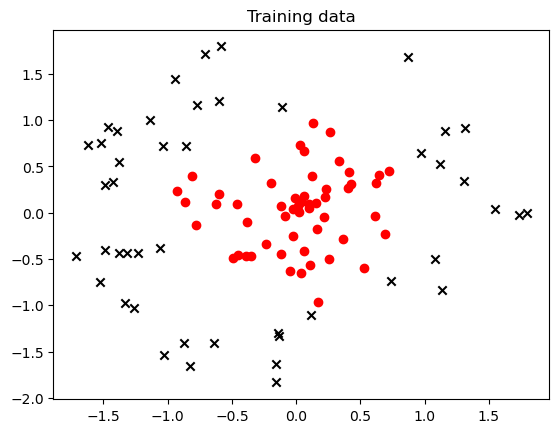

In [73]:
#---------------Plot the training data
fig, ax = plt.subplots()
for numpoint, point in enumerate(X_train):
    ax.scatter(point[0], point[1], c='black' if y_train[numpoint]==1 else 'red', marker='x' if y_train[numpoint]==1 else 'o')
ax.set_title('Training data')

### Start Training

In [74]:
T=600

# Start training
train_adaboost = AdaBoost(X_train, y_train, T)
train_adaboost.train()

### Plot training and testing accuracy

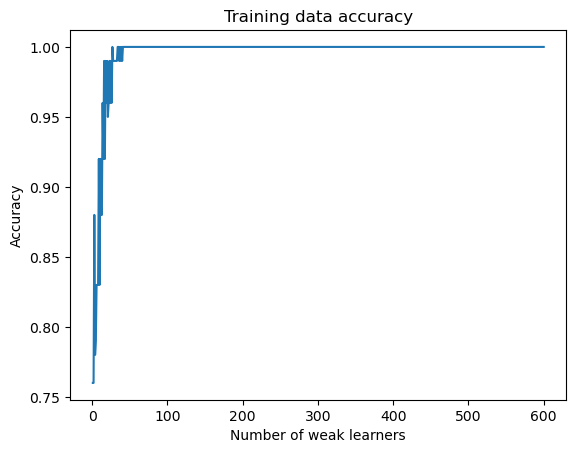

In [75]:
# Plot training data accuracy
accuracy_score = []
for t in range(T):
    accuracy_score.append(train_adaboost.accuracy_K(X_train, y_train, t + 1))
plt.plot(range(1, T + 1), accuracy_score)
plt.xlabel('Number of weak learners')
plt.ylabel('Accuracy')
plt.title('Training data accuracy')
plt.savefig('Adaboost_train.png', dpi = 400)
plt.show()

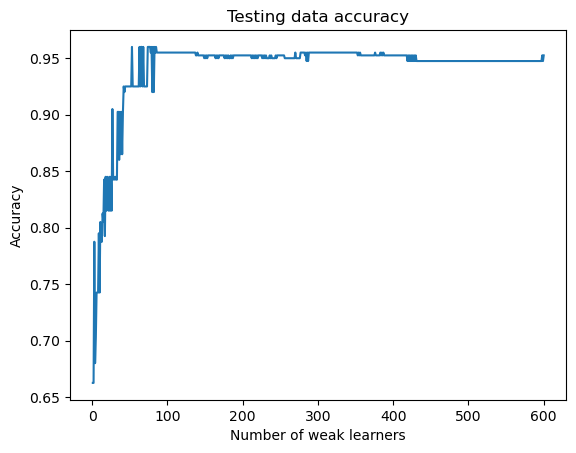

In [76]:
# Plot testing data accuracy
accuracy_score = []
for t in range(T):
    accuracy_score.append(train_adaboost.accuracy_K(X_test, y_test, t + 1))
plt.plot(range(1, T + 1), accuracy_score)
plt.xlabel('Number of weak learners')
plt.ylabel('Accuracy')
plt.title('Testing data accuracy')
plt.savefig('Adaboost_test.png', dpi = 400)
plt.show()

### Plot the data points and the decision boundary using k weak learners

Plotting the data points and the decision boundary using 1 weak learners
Plotting the data points and the decision boundary using 5 weak learners
Plotting the data points and the decision boundary using 10 weak learners
Plotting the data points and the decision boundary using 20 weak learners
Plotting the data points and the decision boundary using 30 weak learners
Plotting the data points and the decision boundary using 100 weak learners
Plotting the data points and the decision boundary using 200 weak learners
Plotting the data points and the decision boundary using 400 weak learners
Plotting the data points and the decision boundary using 600 weak learners


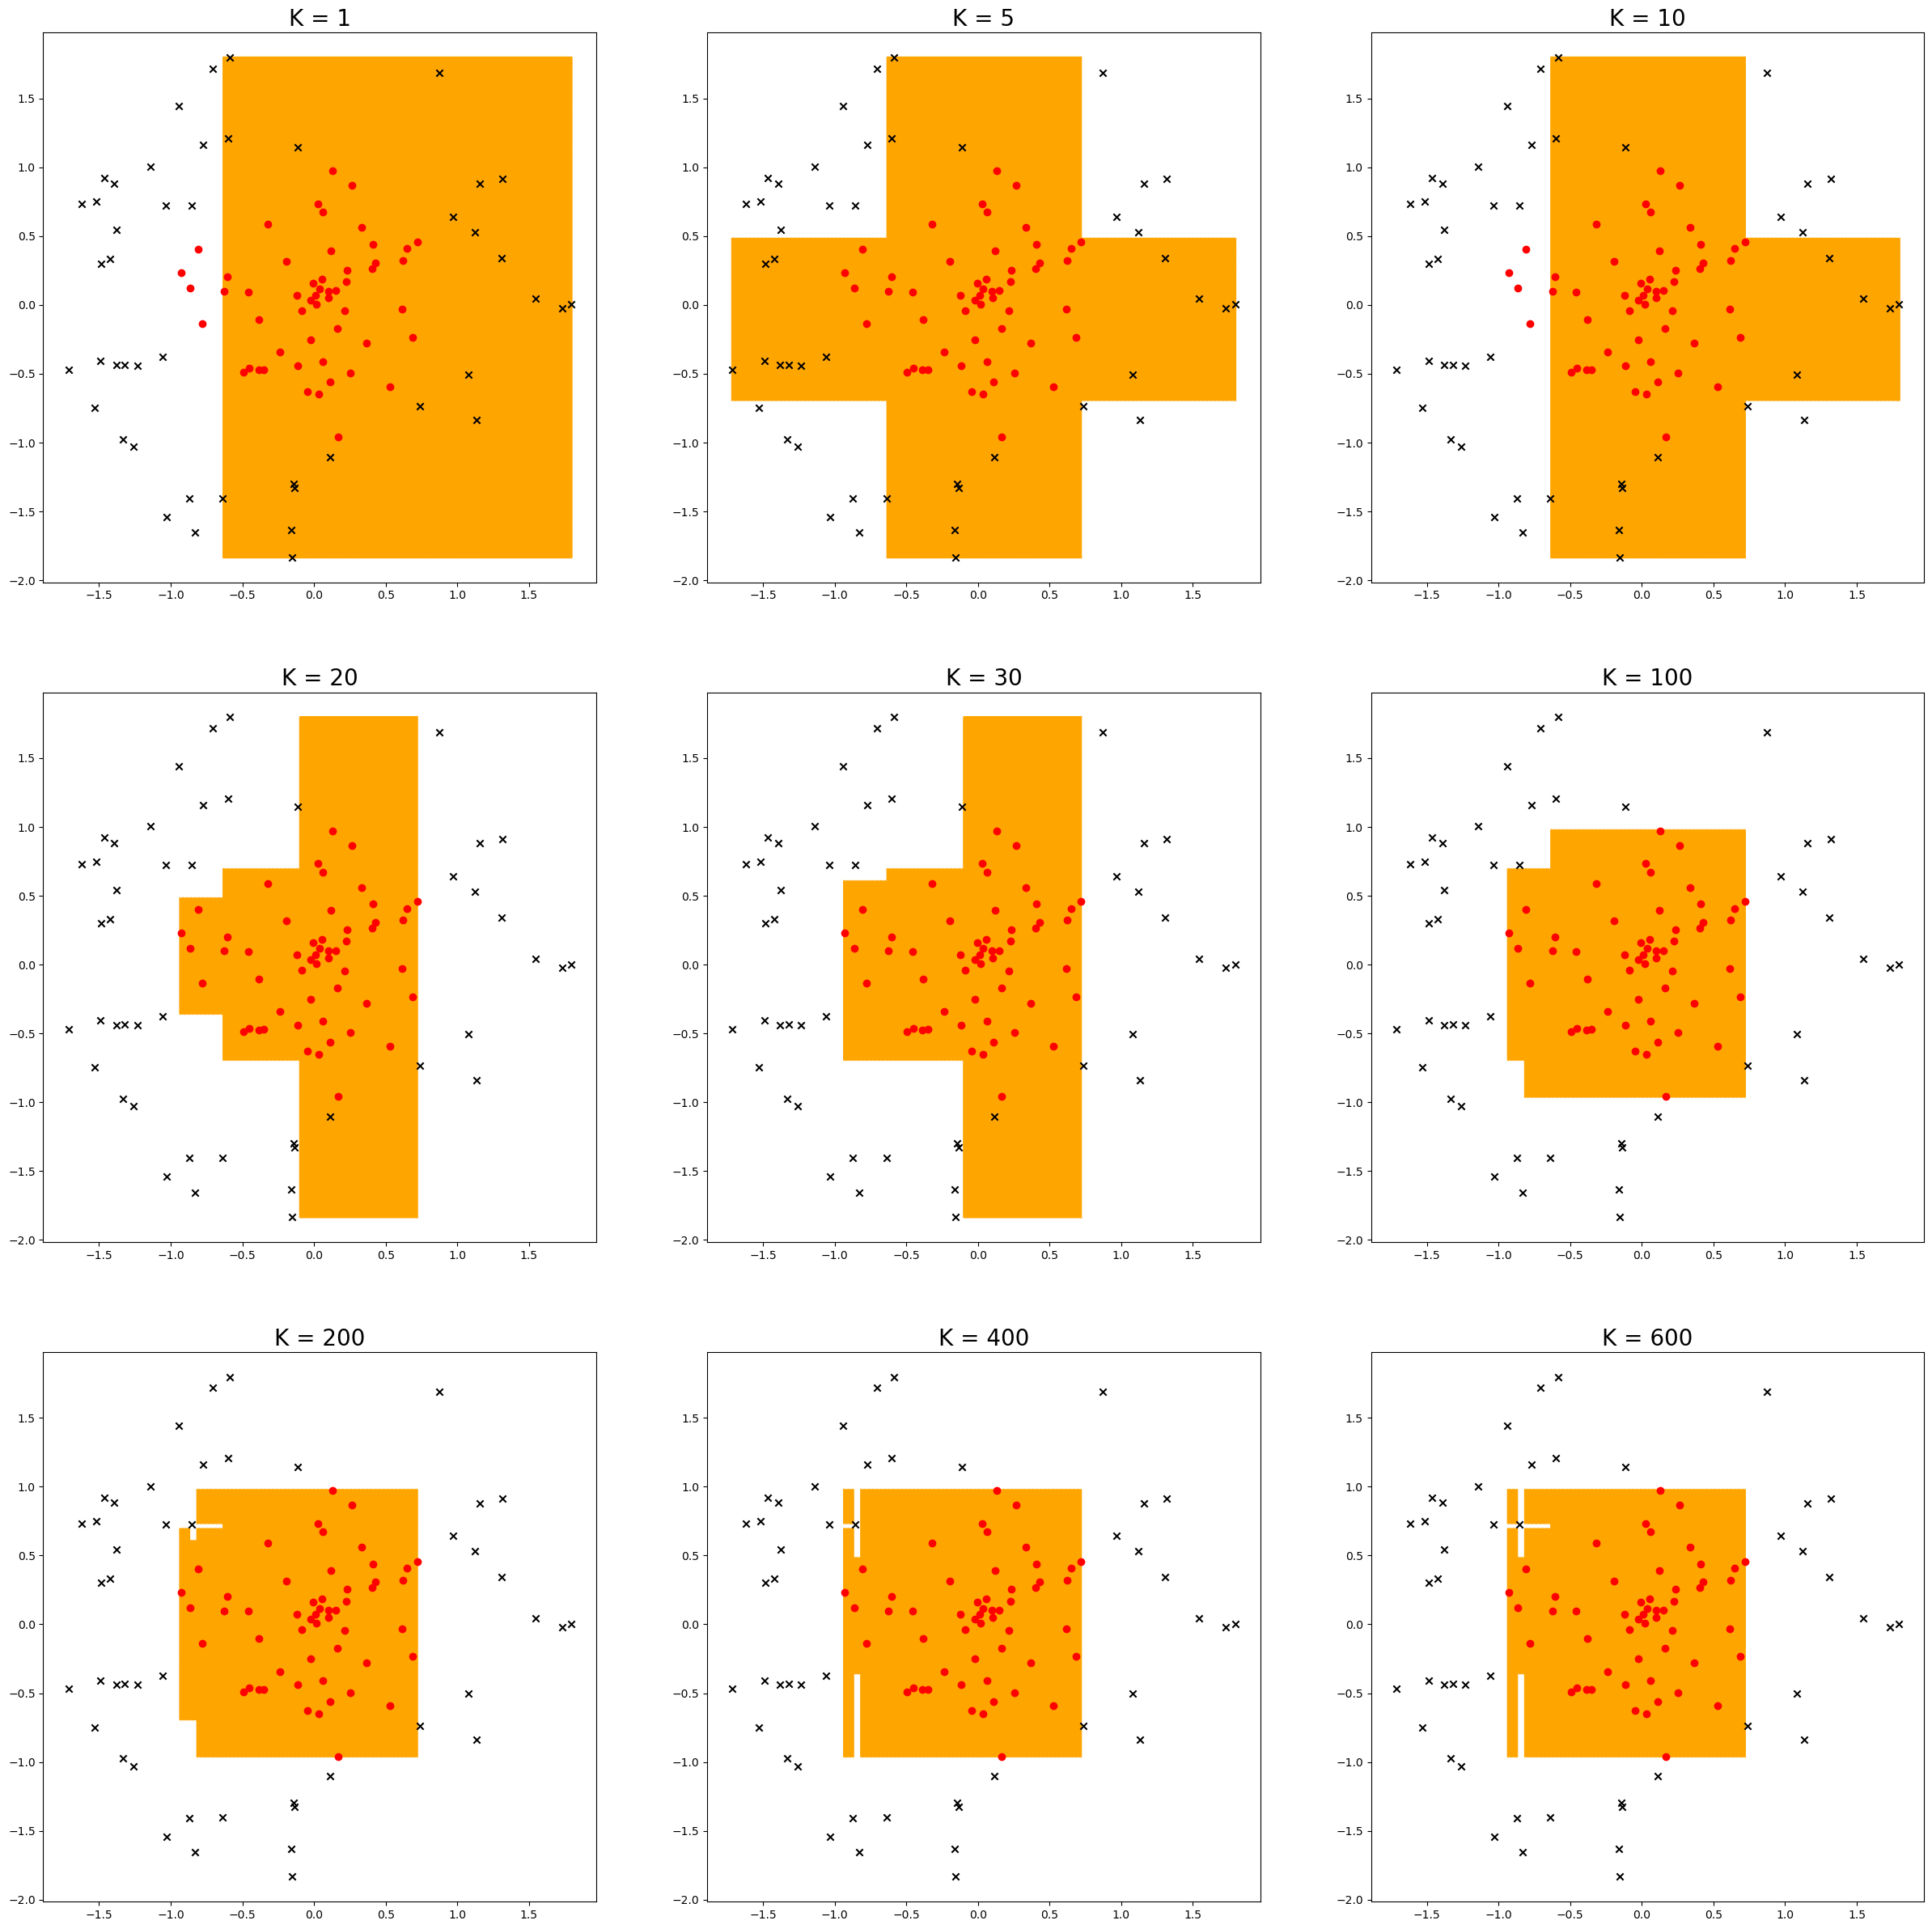

In [77]:
train_adaboost.scatter_plot()